<a href="https://colab.research.google.com/github/angeloken/Riset-I-smile/blob/main/Time_Series_Analysis_Electricity_Consume_Predicting_using_LSTM_(Tensorflow).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import Library**

In [ ]:
from datetime import datetime, timedelta
from dateutil import parser
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from datetime import datetime
import requests
import tensorflow as tf
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#**Import Data**

In [ ]:
df = pd.read_csv('opsd_germany_daily.csv')
df

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


#**Feature Selection**

In [ ]:
df = df[['Date', 'Consumption']]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(df['Date'],inplace=True)
df.drop(columns='Date', axis=1, inplace=True)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Consumption
Date,
2006-01-01,1069.18400
2006-01-02,1380.52100
2006-01-03,1442.53300
2006-01-04,1457.21700
2006-01-05,1477.13100
...,...
2017-12-27,1263.94091
2017-12-28,1299.86398
2017-12-29,1295.08753


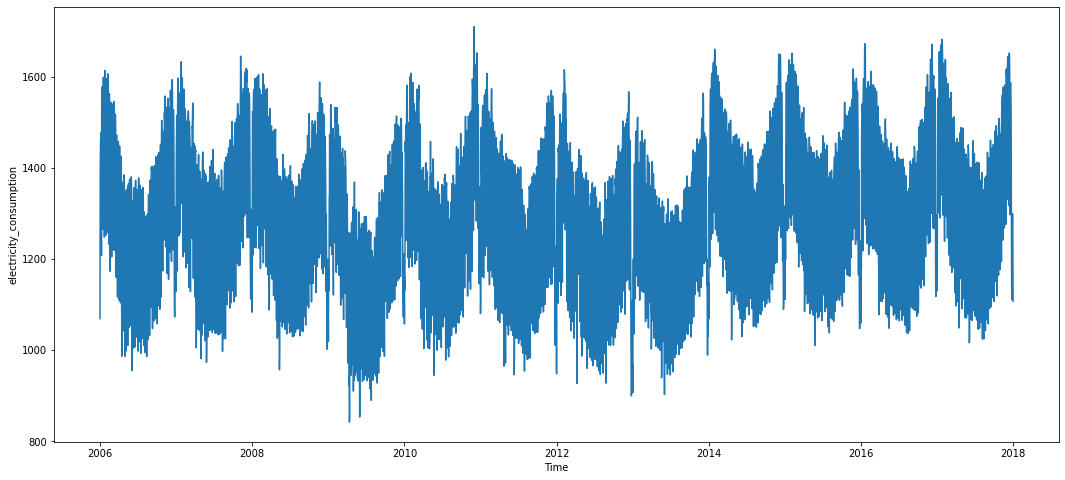

In [ ]:
plt.figure(figsize=(18, 8))
plt.plot(df['Consumption'])
plt.xlabel('Time')
plt.ylabel('electricity_consumption')
plt.grid(False)
plt.show()

#**Preprocessing & Dataset Splitting**

In [ ]:
#df = df.values
#df

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data

array([[-1.62582675],
       [ 0.25244916],
       [ 0.62656353],
       ...,
       [-0.26296542],
       [-0.74341968],
       [-1.39699221]])

#**Train Split Function**

In [ ]:
def train_split(dataframe, split):
  data_array = dataframe
  training_len = int(np.ceil(len(data_array)*split))
  scaled_data = data_array

  train_data = scaled_data[0:int(training_len), :]
  X_train = []
  y_train = []
  for i in range(24, len(train_data)):
      X_train.append(train_data[i-24:i, 0])
      y_train.append(train_data[i, 0])
  
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

  return X_train, y_train, training_len, scaled_data, data_array

In [ ]:
X_train_70, y_train_70, training_len_70, scaled_data, data_array = train_split(dataframe=scaled_data, split=.80)

#**Architecture Model**

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, return_sequences=False, input_shape = (X_train_70.shape[1], 1)),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(X_train_70, y_train_70, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


109/109 [==============================] - 2s 4ms/step - loss: 0.4308 - mae: 0.8069 - lr: 1.0000e-06
Epoch 2/100
109/109 [==============================] - 0s 4ms/step - loss: 0.4307 - mae: 0.8068 - lr: 1.1220e-06
Epoch 3/100
109/109 [==============================] - 1s 5ms/step - loss: 0.4306 - mae: 0.8067 - lr: 1.2589e-06
Epoch 4/100
109/109 [==============================] - 0s 4ms/step - loss: 0.4305 - mae: 0.8066 - lr: 1.4125e-06
Epoch 5/100
109/109 [==============================] - 0s 4ms/step - loss: 0.4304 - mae: 0.8065 - lr: 1.5849e-06
Epoch 6/100
109/109 [==============================] - 0s 4ms/step - loss: 0.4303 - mae: 0.8064 - lr: 1.7783e-06
Epoch 7/100
109/109 [==============================] - 0s 4ms/step - loss: 0.4302 - mae: 0.8063 - lr: 1.9953e-06
Epoch 8/100
109/109 [==============================] - 0s 4ms/step - loss: 0.4300 - mae: 0.8061 - lr: 2.2387e-06
Epoch 9/100
109/109 [==============================] - 0s 4ms/step - loss: 0.4298 - mae: 0.8060 - lr: 2.5119

#**Testing Dataset**

In [ ]:
scaled_data_test = scaler.transform(df)
scaled_data_test

array([[-1.62582675],
       [ 0.25244916],
       [ 0.62656353],
       ...,
       [-0.26296542],
       [-0.74341968],
       [-1.39699221]])

In [ ]:
def test_split(training_len, scaled_data_test):
  scaled_test = scaled_data_test
  test_data = scaled_test[training_len - 24:, :]

  X_test = []
  y_test = data_array[training_len:, :]
  for i in range(24, len(test_data)):
    X_test.append(test_data[i-24:i, 0])

  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  return X_test, y_test, test_data

In [ ]:
X_test_30, y_test_30, test_data_30 = test_split(training_len_70, scaled_data_test)

#**Model Predicting**

In [ ]:
def predict(X_test, model):
  predictions = model.predict(X_test)
  predictions
  
  return predictions

In [ ]:
predictions_30 = predict(X_test_30, model)
predictions_30

28/28 [==============================] - 0s 3ms/step


array([[-1.7352648 ],
       [ 0.45505822],
       [ 0.31698734],
       [ 0.20136395],
       [ 0.17120194],
       [ 0.02818095],
       [-1.082835  ],
       [-1.7834953 ],
       [ 0.42108697],
       [ 0.31019473],
       [ 0.1445341 ],
       [ 0.02701768],
       [-0.07733625],
       [-1.1822411 ],
       [-1.812597  ],
       [ 0.38773745],
       [ 0.41395286],
       [ 0.2948846 ],
       [ 0.25851208],
       [ 0.19192816],
       [-1.0209142 ],
       [-1.6908928 ],
       [ 0.5455693 ],
       [ 0.54218024],
       [ 0.5502164 ],
       [ 0.3465549 ],
       [ 0.17117728],
       [-0.93058705],
       [-1.6205032 ],
       [ 0.63072014],
       [ 0.52148724],
       [ 0.43773678],
       [ 0.3258693 ],
       [ 0.17556396],
       [-0.85492575],
       [-1.5802588 ],
       [ 0.6205408 ],
       [ 0.6484668 ],
       [ 0.55041796],
       [ 0.5775642 ],
       [ 0.4546955 ],
       [-0.7898911 ],
       [-1.5266418 ],
       [ 0.55168754],
       [ 0.56535304],
       [ 0

In [ ]:
predictions_inverse_30 = scaler.inverse_transform(predictions_30)
predictions_inverse_30

array([[1051.044  ],
       [1414.1049 ],
       [1391.2186 ],
       [1372.0532 ],
       [1367.0537 ],
       [1343.347  ],
       [1159.1886 ],
       [1043.0493 ],
       [1408.4739 ],
       [1390.0928 ],
       [1362.6333 ],
       [1343.1542 ],
       [1325.8568 ],
       [1142.7113 ],
       [1038.2256 ],
       [1402.9459 ],
       [1407.2914 ],
       [1387.5549 ],
       [1381.526  ],
       [1370.4893 ],
       [1169.4524 ],
       [1058.3988 ],
       [1429.1077 ],
       [1428.5459 ],
       [1429.8779 ],
       [1396.1196 ],
       [1367.0497 ],
       [1184.4247 ],
       [1070.0664 ],
       [1443.222  ],
       [1425.1158 ],
       [1411.2336 ],
       [1392.6909 ],
       [1367.7767 ],
       [1196.9661 ],
       [1076.7372 ],
       [1441.5347 ],
       [1446.1636 ],
       [1429.9114 ],
       [1434.411  ],
       [1414.0447 ],
       [1207.746  ],
       [1085.6245 ],
       [1430.1218 ],
       [1432.387  ],
       [1430.7891 ],
       [1424.8427 ],
       [1391.

#**Model Evaluate**

In [ ]:
var=explained_variance_score(y_test_30, predictions_30) 
mae=mean_absolute_error(y_test_30, predictions_30)
mse=mean_squared_error (y_test_30, predictions_30)
rmse=np.sqrt(mse)
r2=r2_score(y_test_30, predictions_30)  
metric=[var,mae,mse,rmse,r2]
evaluate=['Explained variance','MAE','MSE','RMSE','R^2']
performance_evaluate=pd.DataFrame([evaluate,metric])
performance_evaluate

,0,1,2,3,4
0,Explained variance,MAE,MSE,RMSE,R^2
1,0.885169,0.243194,0.121493,0.348558,0.871196


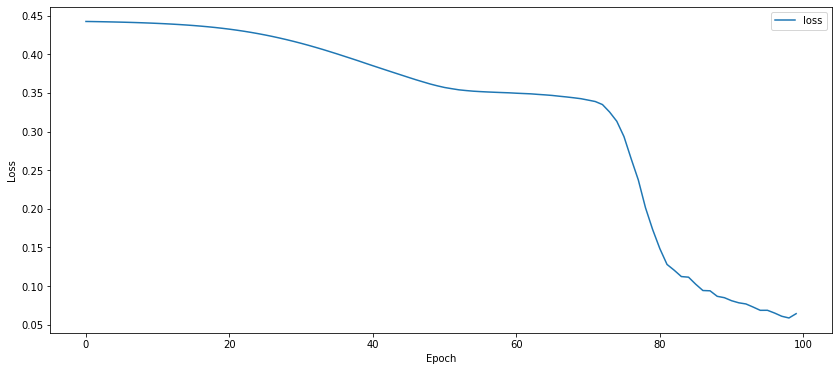

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(history.history["loss"], label="loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#**Transform Ndarray to Dataframe**

In [ ]:
def compare(dataframe, training_len, predictions):
  train = df[:training_len]
  valid = df[training_len:]
  valid['Predictions'] = predictions
  
  return train, valid

In [ ]:
train_70, valid_30 = compare(df, training_len_70, predictions_inverse_30)
valid_30

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Consumption,Predictions
Date,,
2014-05-28,1441.62200,1473.623047
2014-05-29,1128.15100,1415.968750
2014-05-30,1261.20800,1182.469238
2014-05-31,1147.44000,1107.027100
2014-06-01,1068.98200,1065.739136
...,...,...
2017-12-27,1263.94091,1202.409180
2017-12-28,1299.86398,1241.270142
2017-12-29,1295.08753,1247.974976


In [ ]:
valid_30.to_csv('data_predicted LSTM.csv')

In [ ]:
valid_30.tail()

,Consumption,Predictions
Date,,
2017-12-27,1263.94091,1202.409180
2017-12-28,1299.86398,1241.270142
2017-12-29,1295.08753,1247.974976
2017-12-30,1215.44897,1119.246094
2017-12-31,1107.11488,1058.935181


In [ ]:
def plot_predict(train, valid):
  plot = plt.figure(figsize=(17, 7))
  plot = plt.plot(train['Consumption'], label = "Traning", c = "b")
  plot = plt.plot(valid['Consumption'], label = "Validation", c = "g")
  plot = plt.plot(valid['Predictions'], label = "Predict", c = "r")
  plot = plt.legend()
  plot = plt.show()

  return plot

In [102]:
valid_30['FBProphet'] = valid['yhat']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
valid_30['LSTM'] = valid_30['Predictions']
valid_30.drop(columns='Predictions',inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [106]:
valid_30.to_csv('comparison_prediction.csv')

In [88]:
prop_df = pd.read_csv('/content/prophet_prediction.csv')

In [89]:
val_prop=prop_df[-1314:]


In [96]:
valid = val_prop.copy()
valid

,ds,yhat,yhat_lower,yhat_upper,y
3069,2014-05-28,1385.617971,1305.425371,1462.162585,1441.62200
3070,2014-05-29,1372.989696,1295.797470,1455.813289,1128.15100
3071,2014-05-30,1346.717159,1264.151199,1432.060607,1261.20800
3072,2014-05-31,1152.831203,1071.757544,1232.855106,1147.44000
3073,2014-06-01,1056.153185,978.175896,1138.059165,1068.98200
...,...,...,...,...,...
4378,2017-12-27,1387.780657,1303.233818,1467.315330,1263.94091
4379,2017-12-28,1374.087171,1294.634481,1451.639100,1299.86398
4380,2017-12-29,1348.551706,1266.445636,1428.629274,1295.08753
4381,2017-12-30,1157.201934,1080.732552,1237.137974,1215.44897


In [107]:
valid_30

,Consumption,LSTM,FBProphet
Date,,,
2014-05-28,1441.62200,1473.623047,1385.617971
2014-05-29,1128.15100,1415.968750,1372.989696
2014-05-30,1261.20800,1182.469238,1346.717159
2014-05-31,1147.44000,1107.027100,1152.831203
2014-06-01,1068.98200,1065.739136,1056.153185
...,...,...,...
2017-12-27,1263.94091,1202.409180,1387.780657
2017-12-28,1299.86398,1241.270142,1374.087171
2017-12-29,1295.08753,1247.974976,1348.551706


In [97]:
valid['Date'] = valid['ds']

In [100]:
valid['Date'] = pd.to_datetime(valid['Date'])
valid.set_index(valid['Date'],inplace=True)

In [ ]:
val_prop.drop(columns=['ds','yhat_lower','yhat_upper','y'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


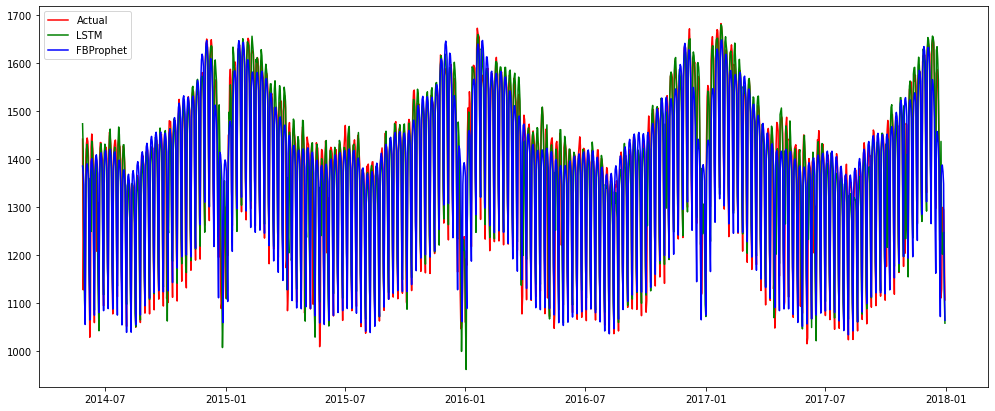

In [110]:
plot = plt.figure(figsize=(17, 7))
plot = plt.plot(valid_30['Consumption'], label = "Actual", c = "r")
plot = plt.plot(valid_30['LSTM'], label = "LSTM", c = "g")
plot = plt.plot(valid_30['FBProphet'], label = "FBProphet", c = "b")
plot = plt.legend()
plot = plt.show()

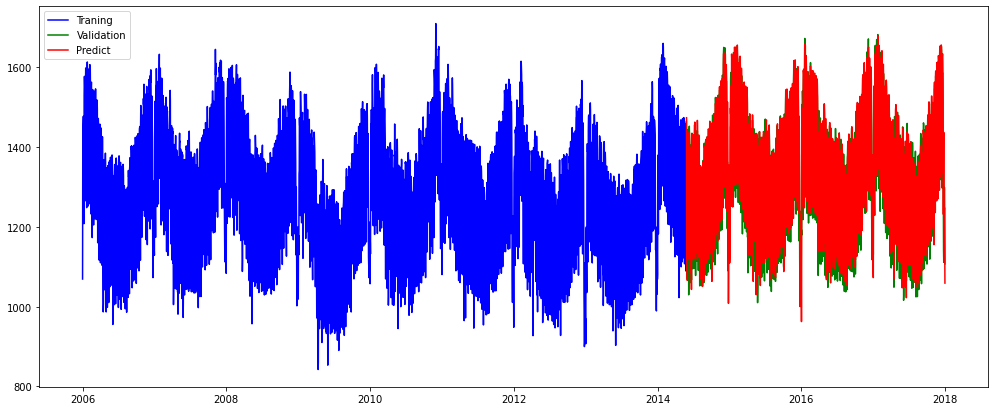

In [ ]:
plot_predict_70_30 = plot_predict(train_70, valid_30)
plot_predict_70_30